In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow import keras
import requests
import zipfile
from pathlib import Path
import time,sys,random
import progressbar

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
drive = '/content/drive/MyDrive/'

Mounted at /content/drive


In [ ]:
MODEL= drive+'model'


In [ ]:
# Setup path to data folder
data_path = Path(drive)
image_path = data_path / 'NDB-UFES An oral cancer and leukoplakia dataset composed of histopathological images and patient data' / 'patch'


In [ ]:
# with zipfile.ZipFile(image_path/'images.zip', "r") as zip_ref:
#         print("Unzipping data...")
#         zip_ref.extractall(image_path)

In [ ]:
for dirpath, dirnames, filenames in os.walk(image_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 1 directories and 2 images in '/content/drive/MyDrive/NDB-UFES An oral cancer and leukoplakia dataset composed of histopathological images and patient data/patch'.
There are 0 directories and 3763 images in '/content/drive/MyDrive/NDB-UFES An oral cancer and leukoplakia dataset composed of histopathological images and patient data/patch/images'.


In [ ]:
image_path

PosixPath('/content/drive/MyDrive/NDB-UFES An oral cancer and leukoplakia dataset composed of histopathological images and patient data/patch')

In [ ]:
df_train_raw = pd.read_csv(image_path/'sabpatch_parsed_folders.csv')
df_test = pd.read_csv(image_path/'sabpatch_parsed_test.csv')
df_test.sample(3)

,path,lesion,folder,label_number
354,p3490.png,With dysplasia,6,2
381,p3517.png,With dysplasia,6,2
334,p3470.png,With dysplasia,6,2


In [ ]:
# df['res'] = df.diagnosis + df.fillna('').dysplasia_severity
# df_x = df[['localization',
#        'larger_size', 'tobacco_use', 'alcohol_consumption', 'sun_exposure',
#        'gender', 'skin_color', 'age_group', 'res']]
# x_df = df_x.drop(columns='res')
# x_df_img = df.path
# y_df = df_x.res

In [ ]:
# class_to_idx = y_df.unique()
# idx_to_class = {i:j for i, j in enumerate(class_to_idx) }
# idx_to_class

In [ ]:
# df_train_raw.iloc[:,:-4].head(2)
df_train_raw.shape

(3136, 4)

In [ ]:
int(df_train_raw.shape[0]*0.85)

2665

In [ ]:

df_train = df_train_raw[:int(df_train_raw.shape[0]*0.85)]
df_val = df_train_raw[int(df_train_raw.shape[0]*0.85):]
df_train.shape, df_val.shape

((2665, 4), (471, 4))

In [ ]:
def getimg(df):
  image_data = []
  widgets = [' [', progressbar.Timer(format= 'elapsed time: %(elapsed)s'), '] ', progressbar.Bar('='), ' (', progressbar.ETA(), ') ']
  bar = progressbar.ProgressBar(max_value=len(df['path'])-1, widgets=widgets).start()
  for i,j in enumerate(df['path']):
    image_data.append(img_to_array(load_img(image_path/'images'/j, target_size=(277,277)))/255)
    bar.update(i)
  return np.array(image_data)

In [ ]:
train_dataset = getimg(df_train)
val_dataset = getimg(df_val)
test_dataset = getimg(df_test)

 [elapsed time: 0:00:08] |==================================| (ETA:  00:00:00) 

In [ ]:
train_dataset[0].shape

(277, 277, 3)

In [ ]:
idx_class = df_train_raw.lesion.unique().tolist()
class_idx = {j:i for i,j in enumerate(idx_class)}
class_idx, idx_class

({'OSCC': 0, 'Without dysplasia': 1, 'With dysplasia': 2},
 ['OSCC', 'Without dysplasia', 'With dysplasia'])

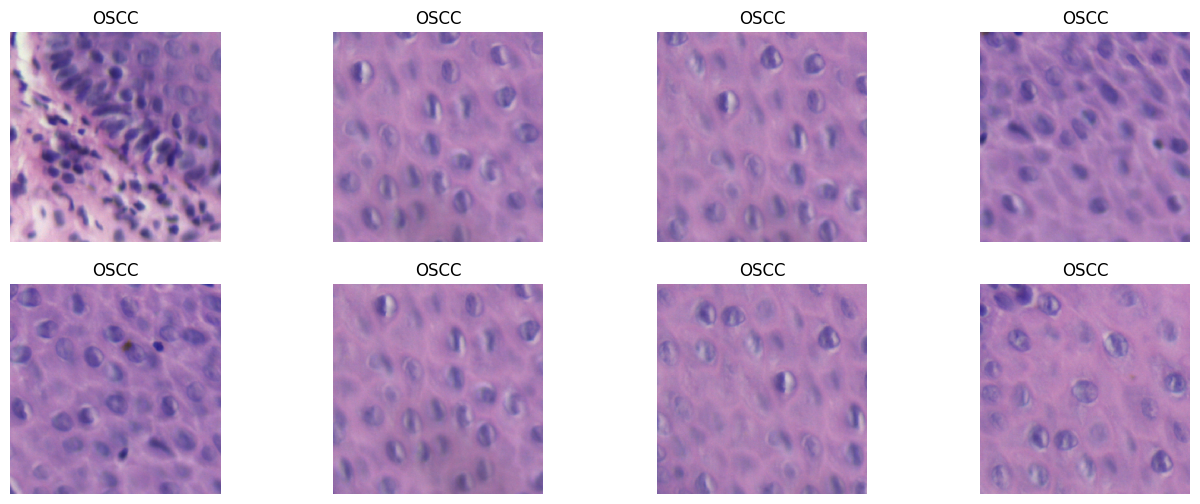

In [ ]:
plt.figure(figsize=(16,6))
for i in range(8):
  plt.subplot(2,4,i+1)
  plt.title(df_train.lesion[i])
  plt.axis('off')
  plt.imshow(train_dataset[i])

In [ ]:
train_output = df_train.lesion.apply(lambda x: class_idx[x]).values
val_output = df_val.lesion.apply(lambda x: class_idx[x]).values
test_output = df_test.lesion.apply(lambda x: class_idx[x]).values

In [ ]:
input_img_shape = train_dataset[0].shape  # (512, 512, 3)
output_shape = len(idx_class) # 3

input_img_shape, output_shape

((277, 277, 3), 3)

In [ ]:

image_input = keras.layers.Input(shape=input_img_shape)

x = keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(64,64,3)) (image_input)
x = keras.layers.BatchNormalization() (x)
x = keras.layers.MaxPool2D(pool_size=(2,2)) (x)

x = keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding='same') (x)
x = keras.layers.BatchNormalization() (x)
x = keras.layers.MaxPool2D(pool_size=(3,3)) (x)

x = keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same') (x)
x = keras.layers.BatchNormalization() (x)

x = keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding='same') (x)
x = keras.layers.BatchNormalization() (x)

x = keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding='same') (x)
x = keras.layers.BatchNormalization() (x)
x = keras.layers.MaxPool2D(pool_size=(2,2)) (x)

x = keras.layers.Flatten() (x)

x = keras.layers.Dense(1024, activation='relu') (x)
x = keras.layers.Dropout(0.5) (x)

x = keras.layers.Dense(1024, activation='relu') (x)
x = keras.layers.Dropout(0.25) (x)

x = keras.layers.Dense(64, activation='relu') (x)

output_layer = keras.layers.Dense(output_shape, activation='softmax') (x)

model = keras.Model(inputs=image_input, outputs=output_layer)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 277, 277, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 67, 67, 128)       46592     
                                                                 
 batch_normalization (Batch  (None, 67, 67, 128)       512       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 33, 33, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 33, 33, 256)       819456    
                                                                 
 batch_normalization_1 (Bat  (None, 33, 33, 256)       1024  

In [ ]:
# loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
# model.compile(optimizer='adam', loss=loss_function, metrics=['accuracy'])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
checkpointPath = data_path / 'model_w' / 'model1' / 'van'



mcp_point = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointPath,
                                                       save_weights_only = True,
                                                       save_best_only = True,
                                                       monitor = 'val_loss',
                                                       verbose = 1)

es_point = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=5,
                                                        verbose=1,
                                                        restore_best_weights=True,
                                                        start_from_epoch=0,)

lr_decay = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                factor=.5,
                                                patience=2,
                                                verbose=1,
                                                mode='auto')

In [ ]:
history = model.fit(train_dataset, train_output, validation_data=(val_dataset, val_output), epochs=10, batch_size=8, callbacks=[es_point])

Epoch 1/10
334/334 [==============================] - 18s 27ms/step - loss: 1.2404 - accuracy: 0.4844 - val_loss: 1.0545 - val_accuracy: 0.6518
Epoch 2/10
334/334 [==============================] - 7s 22ms/step - loss: 0.9883 - accuracy: 0.5122 - val_loss: 0.9026 - val_accuracy: 0.6900
Epoch 3/10
334/334 [==============================] - 7s 21ms/step - loss: 0.9399 - accuracy: 0.5403 - val_loss: 0.9367 - val_accuracy: 0.6837
Epoch 4/10
334/334 [==============================] - 7s 22ms/step - loss: 0.9570 - accuracy: 0.5392 - val_loss: 2.1510 - val_accuracy: 0.1316
Epoch 5/10
334/334 [==============================] - 7s 21ms/step - loss: 0.9396 - accuracy: 0.5445 - val_loss: 1.1276 - val_accuracy: 0.6518
Epoch 6/10
334/334 [==============================] - 7s 22ms/step - loss: 0.9016 - accuracy: 0.5535 - val_loss: 0.9558 - val_accuracy: 0.6879
Epoch 7/10
334/334 [==============================] - 8s 23ms/step - loss: 0.8978 - accuracy: 0.5602 - val_loss: 1.5690 - val_accuracy: 0.683

In [ ]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,loss,accuracy,val_loss,val_accuracy
0,1.240404,0.484428,1.054493,0.651805
1,0.988276,0.512195,0.902581,0.690021
2,0.939938,0.540338,0.936683,0.683652
3,0.957019,0.539212,2.150953,0.131635
4,0.939617,0.544465,1.127562,0.651805


Exception ignored in: <function _xla_gc_callback at 0x7de9643b3880>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


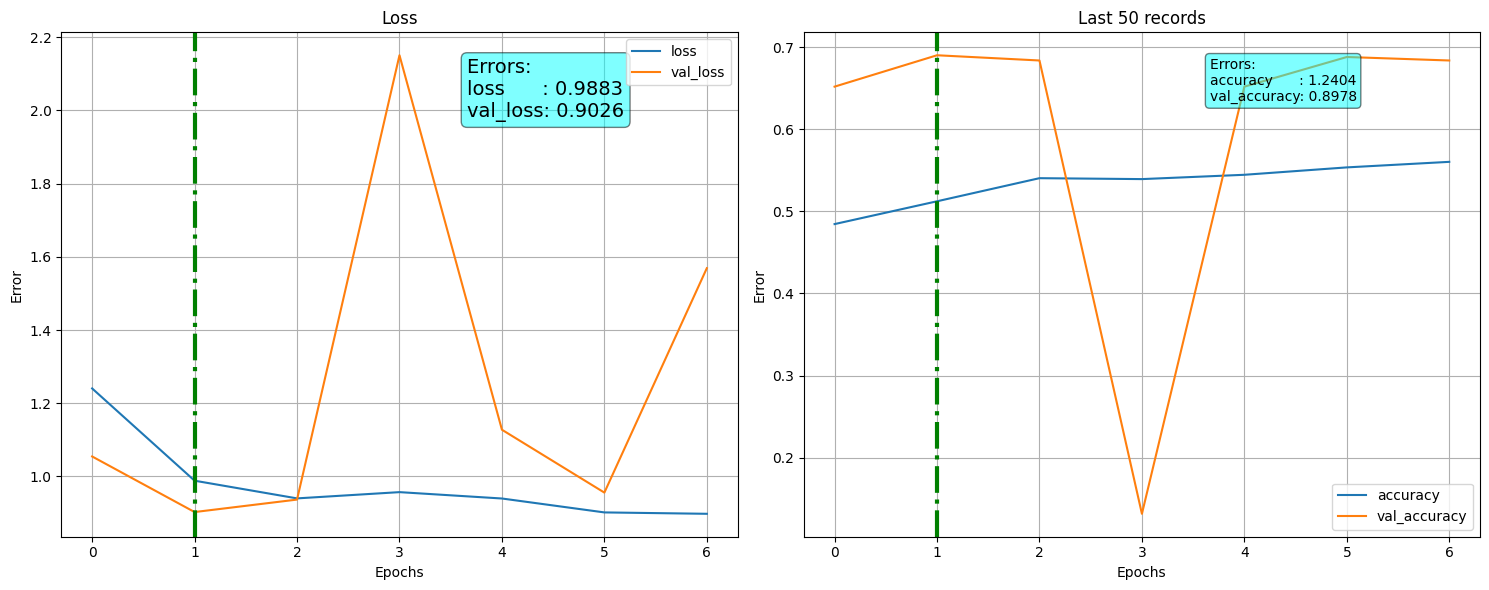

In [ ]:
fig, axes = plt.subplots(1,2 , figsize = (15,6))
props = dict(boxstyle='round', facecolor='aqua',alpha=.5)

l_range = 50
ax = axes[0]
y1=loss_df.columns[0]
y2=loss_df.columns[2]
best = loss_df[loss_df['val_loss'] == loss_df['val_loss'].min()]


loss_df.plot(y=[y1,y2],ax=ax)
ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);
# little beautification
txtstr = "Errors: \nloss      : {:6.4f}\nval_loss: {:6.4f}".format(best.loss.values[0],
                                                                    best.val_loss.values[0]) #text to plot

# place a text box in upper left in axes coords
ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title(y1.capitalize())
ax.grid();

ax = axes[1]

y1=loss_df.columns[1]
y2=loss_df.columns[3]

loss_df.plot(y=[y1,y2],ax=ax)
ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);
# little beautification
txtstr = "Errors: \naccuracy      : {:6.4f}\nval_accuracy: {:6.4f}".format(loss_df.iloc[0]['loss'],
                                                                loss_df.iloc[-1]['loss']) #text to plot


# place a text box in upper left in axes coords
ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('Last {} records'.format(l_range))
ax.grid();
plt.tight_layout()

In [ ]:
loss_df[loss_df['val_loss'] == loss_df['val_loss'].min()]

,loss,accuracy,val_loss,val_accuracy
1,0.988276,0.512195,0.902581,0.690021


In [ ]:
y_pred = model.predict(test_dataset)

In [ ]:
y_pred = [ np.argmax(i) for i in y_pred]
y_test = [ class_idx[i] for i in df_test.lesion.values]

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
# ConfusionMatrixDisplay(df_test.TaskIV.values, np.array(y_pred))